In [1]:
import numpy as np
import pandas as pd
import pickle
import os
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.ensemble import GradientBoostingRegressor
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
os.getcwd()

'C:\\Users\\a.urdin'

In [3]:
os.chdir('/Users/a.urdin/real-estate-price-prediction')

In [718]:
train_df = pd.read_csv('train.csv')

In [719]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [720]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [721]:
train_df['index'] = [x for x in range(len(train_df))]

In [722]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'index']

**LifeSquare - предсказываем по трем признакам общая площадь и количество комнат, площадь кухни, математическая модель

In [723]:
feature_LifeSquare= [#'Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 #'Ecology_1',
 #'Ecology_2',
 #'Ecology_3',
 #'Social_1',
 #'Social_2',
 #'Social_3',
 #'Healthcare_1',
 #'Helthcare_2',
 #'Shops_1',
 #'Shops_2',
 #'Price',
 'index']

In [724]:
train_LifeSquare = train_df[feature_LifeSquare]

In [725]:
train_LifeSquare.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,index
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.00000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,4999.50000
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,2886.89568
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.00000
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,2499.75000
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,4999.50000
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,7499.25000
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,9999.00000


In [726]:
target_LifeSquare = 'LifeSquare'

In [727]:
train_LifeSquare['nan'] = 0
train_LifeSquare.loc[train_LifeSquare[target_LifeSquare].isna(), 'nan'] = 1

<ipython-input-727-647cafad39f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_LifeSquare['nan'] = 0
C:\Users\a.urdin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [728]:
test_LifeSquare = train_LifeSquare[train_LifeSquare['nan'] == 1]
train_LifeSquare = train_LifeSquare[train_LifeSquare['nan'] == 0]

In [729]:
train_LifeSquare.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,index,nan
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,1,0
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,2,0
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,4,0
5,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,5,0
6,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,6,0


In [730]:
test_LifeSquare.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,index,nan
0,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0,1
3,1,1.0,40.409907,NaN,1.0,10,22.0,1977,3,1
18,1,1.0,47.582480,NaN,1.0,16,16.0,1977,18,1
20,63,1.0,50.974891,NaN,1.0,7,16.0,2018,20,1
24,27,1.0,44.203947,NaN,0.0,2,0.0,1977,24,1


In [731]:
train_LifeSquare = train_LifeSquare.drop(columns='nan')
test_LifeSquare = test_LifeSquare.drop(columns='nan')

In [732]:
X = train_LifeSquare.drop(columns=[target_LifeSquare, 'index'])
y = train_LifeSquare[target_LifeSquare].apply(int)

In [733]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.828
Test R2:	0.614


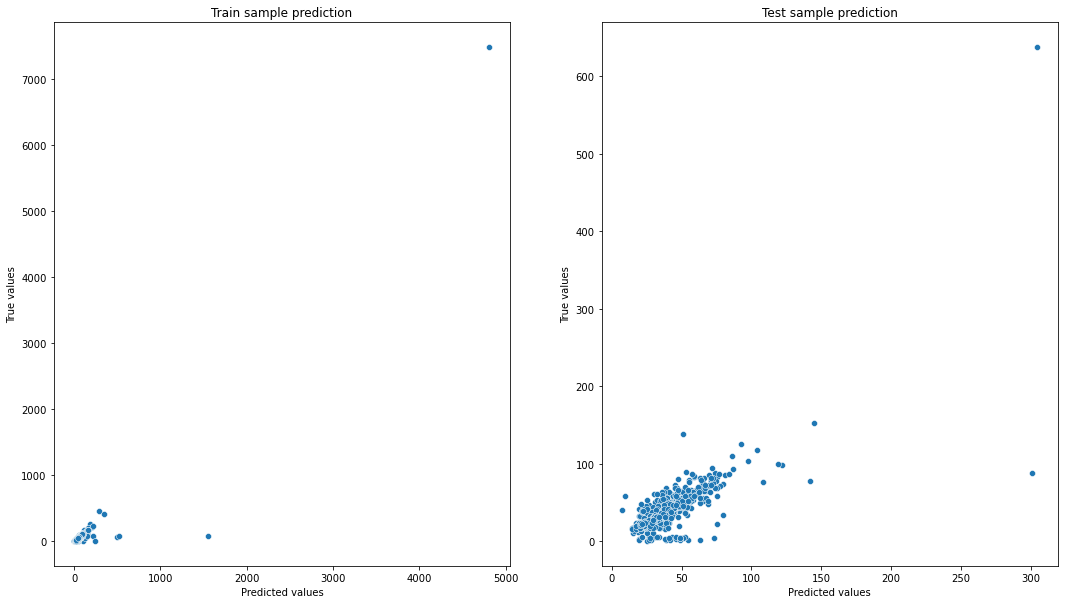

In [734]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=20)

rf_model_LifeSquare = RandomForestRegressor(random_state=21, criterion='mse')
rf_model_LifeSquare.fit(X_train, y_train)

y_train_preds = rf_model_LifeSquare.predict(X_train)
y_test_preds = rf_model_LifeSquare.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [735]:
test_LifeSquare.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,index
0,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0
3,1,1.0,40.409907,NaN,1.0,10,22.0,1977,3
18,1,1.0,47.582480,NaN,1.0,16,16.0,1977,18
20,63,1.0,50.974891,NaN,1.0,7,16.0,2018,20
24,27,1.0,44.203947,NaN,0.0,2,0.0,1977,24


In [736]:
index = [x for x in test_LifeSquare['index']]
test_LifeSquare = test_LifeSquare.drop(columns=[target_LifeSquare, 'index'])

In [737]:
test_LifeSquare[target_LifeSquare] = rf_model_LifeSquare.predict(test_LifeSquare)

In [738]:
test_LifeSquare[target_LifeSquare] = test_LifeSquare[target_LifeSquare].apply(int)

In [739]:
test_LifeSquare['index'] = index

In [740]:
test_LifeSquare.describe()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,LifeSquare,index
count,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000
mean,26.999527,1.778987,60.352646,1.383814,9.913393,13.248935,1981.707525,46.567440,5060.380028
std,24.928012,0.764316,22.846588,2.725244,5.563304,8.091366,12.690541,59.493795,2892.097863
min,0.000000,0.000000,17.414181,0.000000,1.000000,0.000000,1977.000000,6.000000,0.000000
25%,6.000000,1.000000,43.624731,1.000000,5.000000,4.000000,1977.000000,32.000000,2526.000000
50%,23.000000,2.000000,58.634866,1.000000,9.000000,17.000000,1977.000000,42.000000,5084.000000
75%,33.000000,2.000000,68.843287,1.000000,14.000000,17.000000,1977.000000,55.000000,7578.000000
max,190.000000,5.000000,604.705972,62.000000,27.000000,30.000000,2019.000000,2595.000000,9991.000000


In [741]:
train_LifeSquare.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,index
count,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7887.000000,7.887000e+03,7887.000000
mean,56.670217,1.920375,55.234260,37.199645,7.583238,8.155192,12.438063,4.528251e+03,4983.189679
std,45.348356,0.856121,20.419782,86.241209,32.002863,5.087991,6.367352,2.257662e+05,2885.465798
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,1.000000
25%,22.000000,1.000000,41.170089,22.769832,5.000000,4.000000,9.000000,1.971000e+03,2491.500000
50%,46.000000,2.000000,50.872647,32.781260,7.000000,7.000000,12.000000,1.979000e+03,4968.000000
75%,88.000000,3.000000,64.704314,45.128803,9.000000,11.000000,17.000000,2.004000e+03,7477.000000
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,9999.000000


In [742]:
train_LifeSquare = pd.concat([train_LifeSquare, test_LifeSquare]) 

In [743]:
train_LifeSquare.isna().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
index            0
dtype: int64

In [744]:
train_LifeSquare.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'index'],
      dtype='object')

In [745]:
train_df = train_df.drop(columns = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear'])

In [746]:
train_df = train_df.merge(train_LifeSquare, left_on='index', right_on='index', how='left')

**определяем Healthcare_1 - прямая зависимость с Social_2

In [747]:
train_df.columns.tolist()

['Id',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'index',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear']

In [748]:
feature_Healthcare_1 = [#'Id',
 'DistrictId',
 'Floor',
 'HouseFloor',
 'HouseYear',
 #'Ecology_1',
 #'Ecology_2',
 #'Ecology_3',
 #'Social_1',
 'Social_2',
 #'Social_3',
 'Healthcare_1',
 #'Helthcare_2',
 #'Shops_1',
 #'Shops_2',
 #'Price',
 'index',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare'
]

In [749]:
train_Healthcare_1 = train_df[feature_Healthcare_1]

In [750]:
target_Healthcare_1 = 'Healthcare_1'

In [751]:
train_Healthcare_1['nan'] = 0
train_Healthcare_1.loc[train_Healthcare_1[target_Healthcare_1].isna(), 'nan'] = 1

<ipython-input-751-8c365e680824>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_Healthcare_1['nan'] = 0
C:\Users\a.urdin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [752]:
test_Healthcare_1 = train_Healthcare_1[train_Healthcare_1['nan'] == 1]
train_Healthcare_1 = train_Healthcare_1[train_Healthcare_1['nan'] == 0]

In [753]:
train_Healthcare_1 = train_Healthcare_1.drop(columns='nan')
test_Healthcare_1 = test_Healthcare_1.drop(columns='nan')

In [754]:
X = train_Healthcare_1.drop(columns=[target_Healthcare_1,'index'])
y = train_Healthcare_1[target_Healthcare_1].apply(int)

Train R2:	0.997
Test R2:	0.981


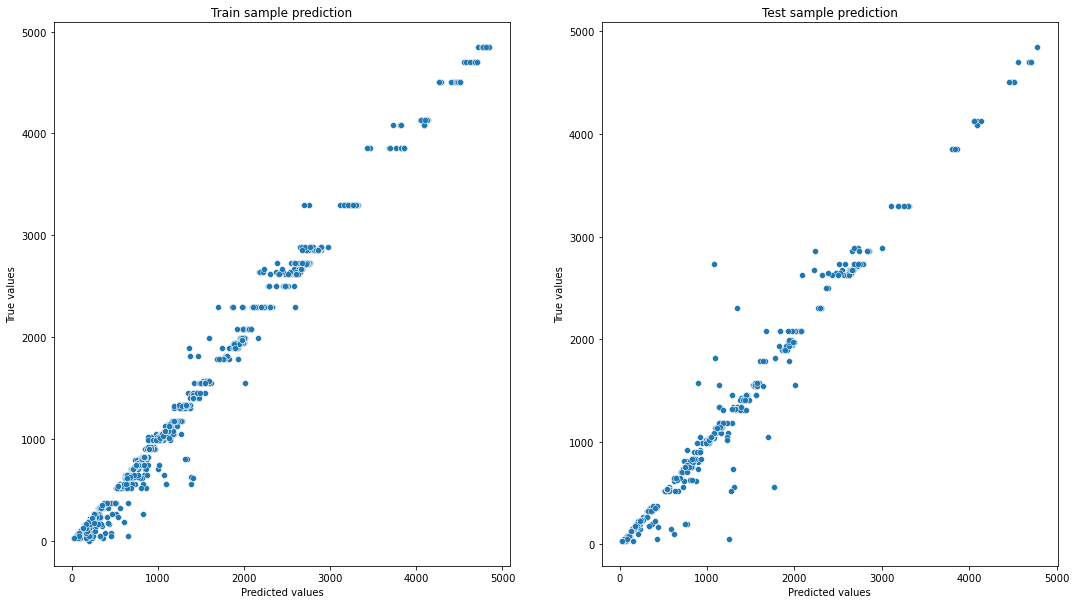

In [755]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=21)

rf_model_Healthcare_1 = RandomForestRegressor(random_state=21, criterion='mse')
rf_model_Healthcare_1.fit(X_train, y_train)

y_train_preds = rf_model_Healthcare_1.predict(X_train)
y_test_preds = rf_model_Healthcare_1.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [756]:
test_Healthcare_1.head()

,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,index,Rooms,Square,LifeSquare,KitchenSquare
0,27,4,10.0,2014,3097,NaN,0,3.0,115.027311,74.000000,10.0
3,1,10,22.0,1977,264,NaN,3,1.0,40.409907,39.000000,1.0
4,94,16,16.0,1972,8667,NaN,4,2.0,64.285067,38.562517,9.0
8,1,12,20.0,1977,264,NaN,8,1.0,46.887892,44.628132,1.0
11,88,2,12.0,1978,8429,NaN,11,2.0,53.975144,34.153584,8.0


In [757]:
index = [x for x in test_Healthcare_1['index']]
test_Healthcare_1 = test_Healthcare_1.drop(columns=[target_Healthcare_1, 'index'])

In [758]:
test_Healthcare_1[target_Healthcare_1] = rf_model_Healthcare_1.predict(test_Healthcare_1)

In [759]:
test_Healthcare_1[target_Healthcare_1] = test_Healthcare_1[target_Healthcare_1].apply(int)

In [760]:
test_Healthcare_1['index'] = index

In [761]:
test_Healthcare_1.describe()

,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Rooms,Square,LifeSquare,KitchenSquare,Healthcare_1,index
count,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000
mean,41.983535,8.867653,12.830763,1987.670488,4737.665069,1.855356,56.989643,42.208133,5.856398,952.104627,5021.792414
std,37.386871,5.358387,6.977174,17.684670,4983.327267,0.859970,19.691782,115.472723,29.563604,686.810560,2878.345908
min,1.000000,1.000000,0.000000,1910.000000,168.000000,0.000000,1.136859,0.641822,0.000000,87.000000,0.000000
25%,23.000000,5.000000,9.000000,1977.000000,629.000000,1.000000,42.040604,26.000000,1.000000,342.000000,2505.500000
50%,27.000000,8.000000,14.000000,1977.000000,3097.000000,2.000000,53.492440,36.506778,6.000000,862.000000,5070.000000
75%,62.000000,12.000000,17.000000,2005.000000,7227.000000,2.000000,66.647835,49.000000,9.000000,1303.000000,7519.500000
max,208.000000,37.000000,99.000000,2020.000000,19083.000000,19.000000,212.932361,7480.592129,2014.000000,4728.000000,9999.000000


In [762]:
train_Healthcare_1.describe()

,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,index,Rooms,Square,LifeSquare,KitchenSquare
count,5202.000000,5202.000000,5202.000000,5.202000e+03,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000
mean,58.164360,8.212226,12.405229,5.837143e+03,5918.926759,1142.904460,4978.938870,1.922914,55.694241,36.385232,6.657824
std,47.304299,5.111028,6.579024,2.779904e+05,2700.135491,1021.517264,2894.883497,0.818937,22.228970,20.690817,27.601105
min,0.000000,1.000000,0.000000,1.912000e+03,528.000000,0.000000,1.000000,0.000000,2.596351,0.370619,0.000000
25%,17.000000,4.000000,9.000000,1.969000e+03,4378.000000,350.000000,2487.750000,1.000000,41.466277,23.269015,5.000000
50%,52.000000,7.000000,12.000000,1.977000e+03,5735.000000,900.000000,4919.500000,2.000000,51.390424,32.897823,6.000000
75%,90.000000,11.000000,17.000000,1.996000e+03,7287.000000,1548.000000,7476.750000,2.000000,65.270484,45.452821,9.000000
max,209.000000,42.000000,117.000000,2.005201e+07,12238.000000,4849.000000,9998.000000,10.000000,641.065193,638.163193,1970.000000


In [763]:
train_Healthcare_1 = pd.concat([train_Healthcare_1, test_Healthcare_1]) 

In [764]:
train_Healthcare_1.describe()

,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,index,Rooms,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,8.526700,12.609400,3.990166e+03,5352.157400,1051.358700,4999.50000,1.890500,56.315775,39.179060,6.273300
std,43.587592,5.241148,6.775974,2.005003e+05,4006.799803,882.137093,2886.89568,0.839512,21.058732,81.413028,28.560917
min,0.000000,1.000000,0.000000,1.910000e+03,168.000000,0.000000,0.00000,0.000000,1.136859,0.370619,0.000000
25%,20.000000,4.000000,9.000000,1.974000e+03,1564.000000,348.000000,2499.75000,1.000000,41.774881,24.000000,1.000000
50%,36.000000,7.000000,13.000000,1.977000e+03,5285.000000,867.000000,4999.50000,2.000000,52.513310,34.103540,6.000000
75%,75.000000,12.000000,17.000000,2.001000e+03,7227.000000,1406.000000,7499.25000,2.000000,65.900625,46.970567,9.000000
max,209.000000,42.000000,117.000000,2.005201e+07,19083.000000,4849.000000,9999.00000,19.000000,641.065193,7480.592129,2014.000000


In [766]:
train_Healthcare_1.columns

Index(['DistrictId', 'Floor', 'HouseFloor', 'HouseYear', 'Social_2',
       'Healthcare_1', 'index', 'Rooms', 'Square', 'LifeSquare',
       'KitchenSquare'],
      dtype='object')

In [767]:
train_df = train_df.drop(columns = ['DistrictId', 'Floor', 'HouseFloor', 'HouseYear', 'Social_2',
       'Healthcare_1', 'Rooms', 'Square', 'LifeSquare',
       'KitchenSquare'])

In [768]:
train_df = train_df.merge(train_Healthcare_1, left_on='index', right_on='index', how='left')

In [769]:
train_df.describe()

,Id,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Price,index,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,Rooms,Square,LifeSquare,KitchenSquare
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,0.118858,24.687000,8.039200,1.319500,4.231300,214138.857399,4999.50000,50.400800,8.526700,12.609400,3.990166e+03,5352.157400,1051.358700,1.890500,56.315775,39.179060,6.273300
std,4859.01902,0.119025,17.532614,23.831875,1.493601,4.806341,92872.293865,2886.89568,43.587592,5.241148,6.775974,2.005003e+05,4006.799803,882.137093,0.839512,21.058732,81.413028,28.560917
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.00000,0.000000,1.000000,0.000000,1.910000e+03,168.000000,0.000000,0.000000,1.136859,0.370619,0.000000
25%,4169.50000,0.017647,6.000000,0.000000,0.000000,1.000000,153872.633942,2499.75000,20.000000,4.000000,9.000000,1.974000e+03,1564.000000,348.000000,1.000000,41.774881,24.000000,1.000000
50%,8394.50000,0.075424,25.000000,2.000000,1.000000,3.000000,192269.644879,4999.50000,36.000000,7.000000,13.000000,1.977000e+03,5285.000000,867.000000,2.000000,52.513310,34.103540,6.000000
75%,12592.50000,0.195781,36.000000,5.000000,2.000000,6.000000,249135.462171,7499.25000,75.000000,12.000000,17.000000,2.001000e+03,7227.000000,1406.000000,2.000000,65.900625,46.970567,9.000000
max,16798.00000,0.521867,74.000000,141.000000,6.000000,23.000000,633233.466570,9999.00000,209.000000,42.000000,117.000000,2.005201e+07,19083.000000,4849.000000,19.000000,641.065193,7480.592129,2014.000000


In [770]:
train_df.to_csv('trainLiveSquareHealthcare.csv', index=False)

In [771]:
df = pd.read_csv('trainLiveSquareHealthcare.csv')

In [772]:
df.describe()

,Id,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Price,index,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,Rooms,Square,LifeSquare,KitchenSquare
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,0.118858,24.687000,8.039200,1.319500,4.231300,214138.857399,4999.50000,50.400800,8.526700,12.609400,3.990166e+03,5352.157400,1051.358700,1.890500,56.315775,39.179060,6.273300
std,4859.01902,0.119025,17.532614,23.831875,1.493601,4.806341,92872.293865,2886.89568,43.587592,5.241148,6.775974,2.005003e+05,4006.799803,882.137093,0.839512,21.058732,81.413028,28.560917
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.00000,0.000000,1.000000,0.000000,1.910000e+03,168.000000,0.000000,0.000000,1.136859,0.370619,0.000000
25%,4169.50000,0.017647,6.000000,0.000000,0.000000,1.000000,153872.633942,2499.75000,20.000000,4.000000,9.000000,1.974000e+03,1564.000000,348.000000,1.000000,41.774881,24.000000,1.000000
50%,8394.50000,0.075424,25.000000,2.000000,1.000000,3.000000,192269.644879,4999.50000,36.000000,7.000000,13.000000,1.977000e+03,5285.000000,867.000000,2.000000,52.513310,34.103540,6.000000
75%,12592.50000,0.195781,36.000000,5.000000,2.000000,6.000000,249135.462171,7499.25000,75.000000,12.000000,17.000000,2.001000e+03,7227.000000,1406.000000,2.000000,65.900625,46.970567,9.000000
max,16798.00000,0.521867,74.000000,141.000000,6.000000,23.000000,633233.466570,9999.00000,209.000000,42.000000,117.000000,2.005201e+07,19083.000000,4849.000000,19.000000,641.065193,7480.592129,2014.000000


In [773]:
os.getcwd()

'C:\\Users\\a.urdin\\real-estate-price-prediction'

In [774]:
os.chdir('/Users/a.urdin/real-estate-price-prediction')

In [775]:
train_df = pd.read_csv('trainLiveSquareHealthcare.csv')

In [776]:
train_df.head()

,Id,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price,...,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,Rooms,Square,LifeSquare,KitchenSquare
0,11809,0.075424,B,B,11,0,0,0,B,305018.871089,...,27,4,10.0,2014,3097,1538.0,3.0,115.027311,74.000000,10.0
1,3013,0.118537,B,B,30,1,1,0,B,177734.553407,...,22,7,8.0,1966,6207,1183.0,1.0,39.832524,23.169223,8.0
2,8215,0.025609,B,B,33,0,3,1,B,282078.720850,...,1,2,17.0,1988,5261,240.0,3.0,78.342215,47.671972,10.0
3,2352,0.007122,B,B,1,0,0,1,B,168106.007630,...,1,10,22.0,1977,264,185.0,1.0,40.409907,39.000000,1.0
4,13866,0.282798,B,B,33,2,0,6,B,343995.102962,...,94,16,16.0,1972,8667,698.0,2.0,64.285067,38.562517,9.0


**Ecology_2, Ecology_3, Shops_2 А = 0, B = 1, С = 2, D = 3!

In [777]:
from sklearn.preprocessing import LabelEncoder

In [778]:
columEncoder =  LabelEncoder()

In [779]:
columEncoder.fit(train_df.Ecology_2)

LabelEncoder()

In [780]:
train_df['Ecology_2'] = columEncoder.transform(train_df.Ecology_2)

In [781]:
columEncoder.fit(train_df.Ecology_3)

LabelEncoder()

In [782]:
train_df['Ecology_3'] = columEncoder.transform(train_df.Ecology_3)

In [783]:
columEncoder.fit(train_df.Shops_2)

LabelEncoder()

In [784]:
train_df['Shops_2'] = columEncoder.transform(train_df.Shops_2)

In [785]:
train_df.describe()

,Id,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price,...,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,Rooms,Square,LifeSquare,KitchenSquare
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,0.118858,0.990300,0.972500,24.687000,8.039200,1.319500,4.231300,0.917500,214138.857399,...,50.400800,8.526700,12.609400,3.990166e+03,5352.157400,1051.358700,1.890500,56.315775,39.179060,6.273300
std,4859.01902,0.119025,0.098015,0.163543,17.532614,23.831875,1.493601,4.806341,0.275139,92872.293865,...,43.587592,5.241148,6.775974,2.005003e+05,4006.799803,882.137093,0.839512,21.058732,81.413028,28.560917
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,...,0.000000,1.000000,0.000000,1.910000e+03,168.000000,0.000000,0.000000,1.136859,0.370619,0.000000
25%,4169.50000,0.017647,1.000000,1.000000,6.000000,0.000000,0.000000,1.000000,1.000000,153872.633942,...,20.000000,4.000000,9.000000,1.974000e+03,1564.000000,348.000000,1.000000,41.774881,24.000000,1.000000
50%,8394.50000,0.075424,1.000000,1.000000,25.000000,2.000000,1.000000,3.000000,1.000000,192269.644879,...,36.000000,7.000000,13.000000,1.977000e+03,5285.000000,867.000000,2.000000,52.513310,34.103540,6.000000
75%,12592.50000,0.195781,1.000000,1.000000,36.000000,5.000000,2.000000,6.000000,1.000000,249135.462171,...,75.000000,12.000000,17.000000,2.001000e+03,7227.000000,1406.000000,2.000000,65.900625,46.970567,9.000000
max,16798.00000,0.521867,1.000000,1.000000,74.000000,141.000000,6.000000,23.000000,1.000000,633233.466570,...,209.000000,42.000000,117.000000,2.005201e+07,19083.000000,4849.000000,19.000000,641.065193,7480.592129,2014.000000


In [786]:
train_df.columns.tolist()

['Id',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'index',
 'DistrictId',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Social_2',
 'Healthcare_1',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare']

In [787]:
feature_Price = [#'Id',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 #'index',
 'DistrictId',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Social_2',
 'Healthcare_1',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare']

In [788]:
train_Price = train_df[feature_Price]

In [789]:
train_Price.describe()

,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,Rooms,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.118858,0.990300,0.972500,24.687000,8.039200,1.319500,4.231300,0.917500,214138.857399,50.400800,8.526700,12.609400,3.990166e+03,5352.157400,1051.358700,1.890500,56.315775,39.179060,6.273300
std,0.119025,0.098015,0.163543,17.532614,23.831875,1.493601,4.806341,0.275139,92872.293865,43.587592,5.241148,6.775974,2.005003e+05,4006.799803,882.137093,0.839512,21.058732,81.413028,28.560917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,1.000000,0.000000,1.910000e+03,168.000000,0.000000,0.000000,1.136859,0.370619,0.000000
25%,0.017647,1.000000,1.000000,6.000000,0.000000,0.000000,1.000000,1.000000,153872.633942,20.000000,4.000000,9.000000,1.974000e+03,1564.000000,348.000000,1.000000,41.774881,24.000000,1.000000
50%,0.075424,1.000000,1.000000,25.000000,2.000000,1.000000,3.000000,1.000000,192269.644879,36.000000,7.000000,13.000000,1.977000e+03,5285.000000,867.000000,2.000000,52.513310,34.103540,6.000000
75%,0.195781,1.000000,1.000000,36.000000,5.000000,2.000000,6.000000,1.000000,249135.462171,75.000000,12.000000,17.000000,2.001000e+03,7227.000000,1406.000000,2.000000,65.900625,46.970567,9.000000
max,0.521867,1.000000,1.000000,74.000000,141.000000,6.000000,23.000000,1.000000,633233.466570,209.000000,42.000000,117.000000,2.005201e+07,19083.000000,4849.000000,19.000000,641.065193,7480.592129,2014.000000


In [790]:
target_Price = 'Price'

In [791]:
X = train_Price.drop(columns=[target_Price])
y = train_Price[target_Price].apply(int)

Train R2:	0.962
Test R2:	0.726


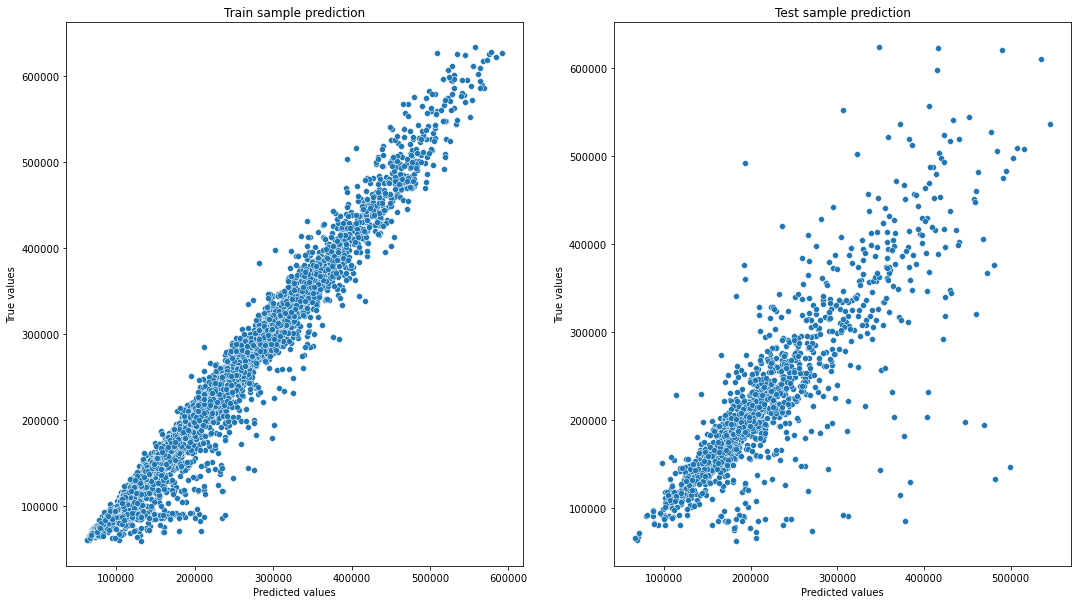

In [792]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=20)

rf_model_Price = RandomForestRegressor(random_state=21, criterion='mse')
rf_model_Price.fit(X_train, y_train)

y_train_preds = rf_model_Price.predict(X_train)
y_test_preds = rf_model_Price.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [793]:
os.getcwd()

'C:\\Users\\a.urdin\\real-estate-price-prediction'

In [794]:
os.chdir('/Users/a.urdin/real-estate-price-prediction')

In [795]:
test_df = pd.read_csv('test.csv')

In [796]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [797]:
test_df['index'] = [x for x in range(len(test_df))]

In [798]:
test_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'index']

In [799]:
feature_LifeSquare= [#'Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 #'Ecology_1',
 #'Ecology_2',
 #'Ecology_3',
 #'Social_1',
 #'Social_2',
 #'Social_3',
 #'Healthcare_1',
 #'Helthcare_2',
 #'Shops_1',
 #'Shops_2',
 'index']

In [800]:
LifeSquare = test_df[feature_LifeSquare]

In [801]:
LifeSquare.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,index
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,2499.500000
std,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,1443.520003
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000
25%,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,1249.750000
50%,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,2499.500000
75%,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,3749.250000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,4999.000000


In [802]:
target_LifeSquare = 'LifeSquare'

In [803]:
LifeSquare.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,index
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,2499.500000
std,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,1443.520003
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000
25%,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,1249.750000
50%,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,2499.500000
75%,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,3749.250000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,4999.000000


In [804]:
LifeSquare['nan'] = 0
LifeSquare.loc[LifeSquare[target_LifeSquare].isna(), 'nan'] = 1

<ipython-input-804-adc207f0050e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LifeSquare['nan'] = 0
C:\Users\a.urdin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [805]:
LifeSquare.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,index,nan
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,2499.500000,0.208200
std,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,1443.520003,0.406061
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000
25%,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,1249.750000,0.000000
50%,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,2499.500000,0.000000
75%,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,3749.250000,0.000000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,4999.000000,1.000000


In [806]:
LifeSquare.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,index,nan
0,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0,0
1,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,1,0
2,27,2.0,59.463678,NaN,9.0,19,19.0,1977,2,1
3,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,3,0
4,74,1.0,53.837056,NaN,1.0,8,17.0,1977,4,1


In [807]:
test_LifeSquare = LifeSquare[LifeSquare['nan'] == 1]
train_LifeSquare = LifeSquare[LifeSquare['nan'] == 0]

In [808]:
train_LifeSquare.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,index,nan
0,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0,0
1,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,1,0
3,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,3,0
5,38,3.0,87.139994,53.180419,10.0,4,23.0,2011,5,0
6,62,1.0,46.269456,22.820239,11.0,8,17.0,2014,6,0


In [809]:
test_LifeSquare.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,index,nan
2,27,2.0,59.463678,NaN,9.0,19,19.0,1977,2,1
4,74,1.0,53.837056,NaN,1.0,8,17.0,1977,4,1
11,9,3.0,80.599472,NaN,1.0,4,1.0,1977,11,1
13,74,1.0,54.614170,NaN,1.0,8,17.0,1977,13,1
14,27,1.0,44.415510,NaN,1.0,14,1.0,1977,14,1


In [810]:
train_LifeSquare = train_LifeSquare.drop(columns='nan')
test_LifeSquare = test_LifeSquare.drop(columns='nan')

In [811]:
test_LifeSquare.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,index
2,27,2.0,59.463678,NaN,9.0,19,19.0,1977,2
4,74,1.0,53.837056,NaN,1.0,8,17.0,1977,4
11,9,3.0,80.599472,NaN,1.0,4,1.0,1977,11
13,74,1.0,54.614170,NaN,1.0,8,17.0,1977,13
14,27,1.0,44.415510,NaN,1.0,14,1.0,1977,14


In [812]:
index = [x for x in test_LifeSquare['index']]
test_LifeSquare = test_LifeSquare.drop(columns=[target_LifeSquare, 'index'])

In [813]:
test_LifeSquare[target_LifeSquare] = rf_model_LifeSquare.predict(test_LifeSquare)

In [814]:
test_LifeSquare[target_LifeSquare] = test_LifeSquare[target_LifeSquare].apply(int)

In [815]:
test_LifeSquare['index'] = index

In [816]:
test_LifeSquare.describe()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,LifeSquare,index
count,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000
mean,27.707973,1.801153,60.448508,1.480307,10.319885,13.254563,1982.261287,49.124880,2551.536984
std,26.446994,0.753095,19.006856,3.107350,6.014444,8.308102,13.310238,66.567864,1452.239136
min,1.000000,1.000000,26.719723,0.000000,1.000000,0.000000,1977.000000,7.000000,2.000000
25%,6.000000,1.000000,44.431455,1.000000,5.000000,3.000000,1977.000000,32.000000,1281.000000
50%,23.000000,2.000000,60.072328,1.000000,9.000000,17.000000,1977.000000,43.000000,2621.000000
75%,33.000000,2.000000,69.877653,1.000000,15.000000,17.000000,1977.000000,56.000000,3823.000000
max,169.000000,6.000000,163.325901,61.000000,28.000000,31.000000,2020.000000,1410.000000,4993.000000


In [817]:
train_LifeSquare.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,index
count,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000
mean,57.477141,1.938621,55.397981,36.158810,7.159131,8.188179,12.429149,1984.953018,2485.817126
std,45.791252,0.857462,18.978272,17.825287,10.760517,5.246159,6.319637,19.688345,1441.090812
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000
25%,23.000000,1.000000,41.381489,23.092026,5.000000,4.000000,9.000000,1970.000000,1245.500000
50%,47.000000,2.000000,50.975474,32.925087,7.000000,7.000000,12.000000,1978.000000,2478.000000
75%,88.000000,3.000000,65.434355,45.174091,9.000000,11.000000,17.000000,2003.000000,3726.000000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,4999.000000


In [818]:
LifeSquare = pd.concat([train_LifeSquare, test_LifeSquare]) 

In [819]:
LifeSquare.isna().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
index            0
dtype: int64

In [820]:
LifeSquare.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'index'],
      dtype='object')

In [821]:
test_df = test_df.drop(columns = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear'])

In [822]:
test_df = test_df.merge(LifeSquare, left_on='index', right_on='index', how='left')

In [823]:
test_df.describe()

,Id,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,index,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8412.595400,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800,2499.500000,51.279200,1.910000,56.449500,38.858346,5.976800,8.632000,12.601000,1984.392600
std,4832.674037,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365,1443.520003,44.179466,0.838594,19.092787,34.658118,9.950018,5.483228,6.789213,18.573149
min,1.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000
25%,4221.750000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000,1249.750000,21.000000,1.000000,41.906231,24.437028,1.000000,4.000000,9.000000,1973.000000
50%,8320.500000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,2499.500000,37.000000,2.000000,52.921340,34.459399,6.000000,7.000000,12.000000,1977.000000
75%,12598.250000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000,3749.250000,77.000000,2.000000,66.285129,47.251672,9.000000,12.000000,17.000000,2000.000000
max,16795.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,4999.000000,212.000000,17.000000,223.453689,1410.000000,620.000000,78.000000,99.000000,2020.000000


# **определяем Healthcare_1 - прямая зависимость с Social_2

In [824]:
test_df.columns.tolist()

['Id',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'index',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear']

In [825]:
feature_Healthcare_1 = [#'Id',
 'DistrictId',
 'Floor',
 'HouseFloor',
 'HouseYear',
 #'Ecology_1',
 #'Ecology_2',
 #'Ecology_3',
 #'Social_1',
 'Social_2',
 #'Social_3',
 'Healthcare_1',
 #'Helthcare_2',
 #'Shops_1',
 #'Shops_2',
 #'Price',
 'index',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare'
]

In [826]:
Healthcare_1 = test_df[feature_Healthcare_1]

In [827]:
target_Healthcare_1 = 'Healthcare_1'

In [828]:
Healthcare_1['nan'] = 0
Healthcare_1.loc[Healthcare_1[target_Healthcare_1].isna(), 'nan'] = 1

<ipython-input-828-6c99a176fdf5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Healthcare_1['nan'] = 0
C:\Users\a.urdin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [829]:
test_Healthcare_1 = Healthcare_1[Healthcare_1['nan'] == 1]
train_Healthcare_1 = Healthcare_1[Healthcare_1['nan'] == 0]

In [830]:
train_Healthcare_1.describe()

,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,index,Rooms,Square,LifeSquare,KitchenSquare,nan
count,2623.000000,2623.00000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.0
mean,58.159741,8.31910,12.233321,1981.486847,5874.217308,1146.657263,2516.886390,1.924133,55.120625,36.424842,6.377812,0.0
std,47.851498,5.50452,6.495061,18.901924,2706.636759,1044.744231,1440.185572,0.852578,18.192294,25.424266,12.701114,0.0
min,0.000000,1.00000,0.000000,1909.000000,528.000000,0.000000,0.000000,0.000000,1.378543,0.809265,0.000000,0.0
25%,17.000000,4.00000,8.000000,1969.000000,4231.000000,325.000000,1263.500000,1.000000,41.218466,23.611767,5.000000,0.0
50%,52.000000,7.00000,12.000000,1977.000000,5664.000000,900.000000,2538.000000,2.000000,50.637273,32.901425,6.000000,0.0
75%,90.000000,11.00000,17.000000,1994.000000,7287.000000,1548.000000,3735.500000,2.000000,65.729097,45.385433,9.000000,0.0
max,212.000000,78.00000,48.000000,2020.000000,12238.000000,4849.000000,4999.000000,17.000000,221.138768,1029.000000,620.000000,0.0


In [831]:
test_Healthcare_1.describe()

,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,index,Rooms,Square,LifeSquare,KitchenSquare,nan
count,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,0.0,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.0
mean,43.686580,8.977282,13.006731,1987.599074,4891.219184,NaN,2480.314262,1.894405,57.915904,41.543698,5.534287,1.0
std,38.337733,5.439937,7.078917,17.660792,5051.857433,NaN,1447.251224,0.822786,19.940871,42.428426,5.468438,0.0
min,1.000000,1.000000,0.000000,1908.000000,168.000000,NaN,1.000000,0.000000,1.975769,0.333490,0.000000,1.0
25%,23.000000,5.000000,9.000000,1977.000000,629.000000,NaN,1226.000000,1.000000,42.540968,26.426549,1.000000,1.0
50%,27.000000,8.000000,14.000000,1977.000000,3806.000000,NaN,2462.000000,2.000000,54.491072,37.000000,6.000000,1.0
75%,62.000000,12.000000,17.000000,2004.000000,7425.000000,NaN,3767.000000,2.000000,66.935126,49.068642,9.000000,1.0
max,210.000000,27.000000,99.000000,2020.000000,19083.000000,NaN,4998.000000,6.000000,223.453689,1410.000000,112.000000,1.0


In [832]:
train_Healthcare_1 = train_Healthcare_1.drop(columns='nan')
test_Healthcare_1 = test_Healthcare_1.drop(columns='nan')

In [833]:
train_Healthcare_1.describe()

,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,index,Rooms,Square,LifeSquare,KitchenSquare
count,2623.000000,2623.00000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000
mean,58.159741,8.31910,12.233321,1981.486847,5874.217308,1146.657263,2516.886390,1.924133,55.120625,36.424842,6.377812
std,47.851498,5.50452,6.495061,18.901924,2706.636759,1044.744231,1440.185572,0.852578,18.192294,25.424266,12.701114
min,0.000000,1.00000,0.000000,1909.000000,528.000000,0.000000,0.000000,0.000000,1.378543,0.809265,0.000000
25%,17.000000,4.00000,8.000000,1969.000000,4231.000000,325.000000,1263.500000,1.000000,41.218466,23.611767,5.000000
50%,52.000000,7.00000,12.000000,1977.000000,5664.000000,900.000000,2538.000000,2.000000,50.637273,32.901425,6.000000
75%,90.000000,11.00000,17.000000,1994.000000,7287.000000,1548.000000,3735.500000,2.000000,65.729097,45.385433,9.000000
max,212.000000,78.00000,48.000000,2020.000000,12238.000000,4849.000000,4999.000000,17.000000,221.138768,1029.000000,620.000000


In [834]:
test_Healthcare_1.head()

,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,index,Rooms,Square,LifeSquare,KitchenSquare
1,62,7,17.0,2017,629,NaN,1,1.0,42.493907,42.568133,10.0
2,27,19,19.0,1977,1892,NaN,2,2.0,59.463678,44.000000,9.0
3,23,2,2.0,1965,475,NaN,3,3.0,49.646030,33.893825,6.0
6,62,8,17.0,2014,629,NaN,6,1.0,46.269456,22.820239,11.0
7,2,4,9.0,1974,7425,NaN,7,2.0,48.172969,29.924204,6.0


In [835]:
index = [x for x in test_Healthcare_1['index']]
test_Healthcare_1 = test_Healthcare_1.drop(columns=[target_Healthcare_1, 'index'])

In [836]:
test_Healthcare_1[target_Healthcare_1] = rf_model_Healthcare_1.predict(test_Healthcare_1)

In [837]:
test_Healthcare_1[target_Healthcare_1] = test_Healthcare_1[target_Healthcare_1].apply(int)

In [838]:
test_Healthcare_1['index'] = index

In [839]:
test_Healthcare_1.describe()

,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Rooms,Square,LifeSquare,KitchenSquare,Healthcare_1,index
count,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000
mean,43.686580,8.977282,13.006731,1987.599074,4891.219184,1.894405,57.915904,41.543698,5.534287,978.228019,2480.314262
std,38.337733,5.439937,7.078917,17.660792,5051.857433,0.822786,19.940871,42.428426,5.468438,726.378411,1447.251224
min,1.000000,1.000000,0.000000,1908.000000,168.000000,0.000000,1.975769,0.333490,0.000000,87.000000,1.000000
25%,23.000000,5.000000,9.000000,1977.000000,629.000000,1.000000,42.540968,26.426549,1.000000,343.000000,1226.000000
50%,27.000000,8.000000,14.000000,1977.000000,3806.000000,2.000000,54.491072,37.000000,6.000000,867.000000,2462.000000
75%,62.000000,12.000000,17.000000,2004.000000,7425.000000,2.000000,66.935126,49.068642,9.000000,1324.000000,3767.000000
max,210.000000,27.000000,99.000000,2020.000000,19083.000000,6.000000,223.453689,1410.000000,112.000000,4705.000000,4998.000000


In [840]:
train_Healthcare_1.describe()

,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,index,Rooms,Square,LifeSquare,KitchenSquare
count,2623.000000,2623.00000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000
mean,58.159741,8.31910,12.233321,1981.486847,5874.217308,1146.657263,2516.886390,1.924133,55.120625,36.424842,6.377812
std,47.851498,5.50452,6.495061,18.901924,2706.636759,1044.744231,1440.185572,0.852578,18.192294,25.424266,12.701114
min,0.000000,1.00000,0.000000,1909.000000,528.000000,0.000000,0.000000,0.000000,1.378543,0.809265,0.000000
25%,17.000000,4.00000,8.000000,1969.000000,4231.000000,325.000000,1263.500000,1.000000,41.218466,23.611767,5.000000
50%,52.000000,7.00000,12.000000,1977.000000,5664.000000,900.000000,2538.000000,2.000000,50.637273,32.901425,6.000000
75%,90.000000,11.00000,17.000000,1994.000000,7287.000000,1548.000000,3735.500000,2.000000,65.729097,45.385433,9.000000
max,212.000000,78.00000,48.000000,2020.000000,12238.000000,4849.000000,4999.000000,17.000000,221.138768,1029.000000,620.000000


In [841]:
Healthcare_1 = pd.concat([train_Healthcare_1, test_Healthcare_1]) 

In [842]:
Healthcare_1.describe()

,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,index,Rooms,Square,LifeSquare,KitchenSquare
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,51.279200,8.632000,12.601000,1984.392600,5406.900000,1066.586000,2499.500000,1.910000,56.449500,38.858346,5.976800
std,44.179466,5.483228,6.789213,18.573149,4026.614773,911.233401,1443.520003,0.838594,19.092787,34.658118,9.950018
min,0.000000,1.000000,0.000000,1908.000000,168.000000,0.000000,0.000000,0.000000,1.378543,0.333490,0.000000
25%,21.000000,4.000000,9.000000,1973.000000,1564.000000,332.750000,1249.750000,1.000000,41.906231,24.437028,1.000000
50%,37.000000,7.000000,12.000000,1977.000000,5285.000000,867.000000,2499.500000,2.000000,52.921340,34.459399,6.000000
75%,77.000000,12.000000,17.000000,2000.000000,7287.000000,1426.000000,3749.250000,2.000000,66.285129,47.251672,9.000000
max,212.000000,78.000000,99.000000,2020.000000,19083.000000,4849.000000,4999.000000,17.000000,223.453689,1410.000000,620.000000


In [843]:
Healthcare_1.columns

Index(['DistrictId', 'Floor', 'HouseFloor', 'HouseYear', 'Social_2',
       'Healthcare_1', 'index', 'Rooms', 'Square', 'LifeSquare',
       'KitchenSquare'],
      dtype='object')

In [844]:
test_df = test_df.drop(columns = ['DistrictId', 'Floor', 'HouseFloor', 'HouseYear', 'Social_2',
       'Healthcare_1', 'Rooms', 'Square', 'LifeSquare',
       'KitchenSquare'])

In [845]:
test_df = test_df.merge(Healthcare_1, left_on='index', right_on='index', how='left')

In [846]:
test_df.describe()

,Id,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,index,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,Rooms,Square,LifeSquare,KitchenSquare
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8412.595400,0.119874,24.933800,8.262600,1.31940,4.242800,2499.500000,51.279200,8.632000,12.601000,1984.392600,5406.900000,1066.586000,1.910000,56.449500,38.858346,5.976800
std,4832.674037,0.120070,17.532202,23.863762,1.47994,4.777365,1443.520003,44.179466,5.483228,6.789213,18.573149,4026.614773,911.233401,0.838594,19.092787,34.658118,9.950018
min,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1908.000000,168.000000,0.000000,0.000000,1.378543,0.333490,0.000000
25%,4221.750000,0.019509,6.000000,0.000000,0.00000,1.000000,1249.750000,21.000000,4.000000,9.000000,1973.000000,1564.000000,332.750000,1.000000,41.906231,24.437028,1.000000
50%,8320.500000,0.072158,25.000000,2.000000,1.00000,3.000000,2499.500000,37.000000,7.000000,12.000000,1977.000000,5285.000000,867.000000,2.000000,52.921340,34.459399,6.000000
75%,12598.250000,0.195781,36.000000,5.000000,2.00000,6.000000,3749.250000,77.000000,12.000000,17.000000,2000.000000,7287.000000,1426.000000,2.000000,66.285129,47.251672,9.000000
max,16795.000000,0.521867,74.000000,141.000000,6.00000,23.000000,4999.000000,212.000000,78.000000,99.000000,2020.000000,19083.000000,4849.000000,17.000000,223.453689,1410.000000,620.000000


In [847]:
from sklearn.preprocessing import LabelEncoder

In [848]:
columEncoder =  LabelEncoder()

In [849]:
columEncoder.fit(test_df.Ecology_2)

LabelEncoder()

In [850]:
test_df['Ecology_2'] = columEncoder.transform(test_df.Ecology_2)

In [851]:
columEncoder.fit(test_df.Ecology_3)

LabelEncoder()

In [852]:
test_df['Ecology_3'] = columEncoder.transform(test_df.Ecology_3)

In [853]:
columEncoder.fit(test_df.Shops_2)

LabelEncoder()

In [854]:
test_df['Shops_2'] = columEncoder.transform(test_df.Shops_2)

In [855]:
test_df.describe()

,Id,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,index,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,Rooms,Square,LifeSquare,KitchenSquare
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8412.595400,0.119874,0.990400,0.970200,24.933800,8.262600,1.31940,4.242800,0.917600,2499.500000,51.279200,8.632000,12.601000,1984.392600,5406.900000,1066.586000,1.910000,56.449500,38.858346,5.976800
std,4832.674037,0.120070,0.097518,0.170052,17.532202,23.863762,1.47994,4.777365,0.275001,1443.520003,44.179466,5.483228,6.789213,18.573149,4026.614773,911.233401,0.838594,19.092787,34.658118,9.950018
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1908.000000,168.000000,0.000000,0.000000,1.378543,0.333490,0.000000
25%,4221.750000,0.019509,1.000000,1.000000,6.000000,0.000000,0.00000,1.000000,1.000000,1249.750000,21.000000,4.000000,9.000000,1973.000000,1564.000000,332.750000,1.000000,41.906231,24.437028,1.000000
50%,8320.500000,0.072158,1.000000,1.000000,25.000000,2.000000,1.00000,3.000000,1.000000,2499.500000,37.000000,7.000000,12.000000,1977.000000,5285.000000,867.000000,2.000000,52.921340,34.459399,6.000000
75%,12598.250000,0.195781,1.000000,1.000000,36.000000,5.000000,2.00000,6.000000,1.000000,3749.250000,77.000000,12.000000,17.000000,2000.000000,7287.000000,1426.000000,2.000000,66.285129,47.251672,9.000000
max,16795.000000,0.521867,1.000000,1.000000,74.000000,141.000000,6.00000,23.000000,1.000000,4999.000000,212.000000,78.000000,99.000000,2020.000000,19083.000000,4849.000000,17.000000,223.453689,1410.000000,620.000000


In [856]:
test_df.columns.tolist()

['Id',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'index',
 'DistrictId',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Social_2',
 'Healthcare_1',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare']

In [863]:
feature_Price = ['Id',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 #'index',
 'DistrictId',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Social_2',
 'Healthcare_1',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare']

In [864]:
test_Price = test_df[feature_Price]

In [865]:
test_Price.describe()

,Id,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,Rooms,Square,LifeSquare,KitchenSquare
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8412.595400,0.119874,0.990400,0.970200,24.933800,8.262600,1.31940,4.242800,0.917600,51.279200,8.632000,12.601000,1984.392600,5406.900000,1066.586000,1.910000,56.449500,38.858346,5.976800
std,4832.674037,0.120070,0.097518,0.170052,17.532202,23.863762,1.47994,4.777365,0.275001,44.179466,5.483228,6.789213,18.573149,4026.614773,911.233401,0.838594,19.092787,34.658118,9.950018
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1908.000000,168.000000,0.000000,0.000000,1.378543,0.333490,0.000000
25%,4221.750000,0.019509,1.000000,1.000000,6.000000,0.000000,0.00000,1.000000,1.000000,21.000000,4.000000,9.000000,1973.000000,1564.000000,332.750000,1.000000,41.906231,24.437028,1.000000
50%,8320.500000,0.072158,1.000000,1.000000,25.000000,2.000000,1.00000,3.000000,1.000000,37.000000,7.000000,12.000000,1977.000000,5285.000000,867.000000,2.000000,52.921340,34.459399,6.000000
75%,12598.250000,0.195781,1.000000,1.000000,36.000000,5.000000,2.00000,6.000000,1.000000,77.000000,12.000000,17.000000,2000.000000,7287.000000,1426.000000,2.000000,66.285129,47.251672,9.000000
max,16795.000000,0.521867,1.000000,1.000000,74.000000,141.000000,6.00000,23.000000,1.000000,212.000000,78.000000,99.000000,2020.000000,19083.000000,4849.000000,17.000000,223.453689,1410.000000,620.000000


In [866]:
target_Price = 'Price'

In [867]:
test_Price.head()

,Id,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,Rooms,Square,LifeSquare,KitchenSquare
0,4567,0.036122,1,1,24,0,1,1,1,44,5,9.0,1970,4378,1036.0,1.0,36.847630,19.094182,5.0
1,5925,0.072158,1,1,2,1,0,0,0,62,7,17.0,2017,629,833.0,1.0,42.493907,42.568133,10.0
2,960,0.211401,1,1,9,0,0,1,1,27,19,19.0,1977,1892,1325.0,2.0,59.463678,44.000000,9.0
3,3848,0.014073,1,1,2,0,0,0,1,23,2,2.0,1965,475,920.0,3.0,49.646030,33.893825,6.0
4,746,0.309479,1,1,35,4,0,6,1,74,8,17.0,1977,7715,990.0,1.0,53.837056,43.000000,1.0


In [868]:
Id = [x for x in test_Price['Id']]
test_Price = test_Price.drop(columns='Id')

In [869]:
test_Price[target_Price] = rf_model_Price.predict(test_Price)

In [870]:
test_Price['Id'] = Id

In [871]:
test_Price.head()

,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,DistrictId,Floor,HouseFloor,HouseYear,Social_2,Healthcare_1,Rooms,Square,LifeSquare,KitchenSquare,Price,Id
0,0.036122,1,1,24,0,1,1,1,44,5,9.0,1970,4378,1036.0,1.0,36.847630,19.094182,5.0,155350.21,4567
1,0.072158,1,1,2,1,0,0,0,62,7,17.0,2017,629,833.0,1.0,42.493907,42.568133,10.0,116742.44,5925
2,0.211401,1,1,9,0,0,1,1,27,19,19.0,1977,1892,1325.0,2.0,59.463678,44.000000,9.0,142063.32,960
3,0.014073,1,1,2,0,0,0,1,23,2,2.0,1965,475,920.0,3.0,49.646030,33.893825,6.0,133869.09,3848
4,0.309479,1,1,35,4,0,6,1,74,8,17.0,1977,7715,990.0,1.0,53.837056,43.000000,1.0,201757.19,746


In [872]:
test_Price[target_Price] = test_Price[target_Price].apply(int)

In [873]:
test_Price.columns.tolist()

['Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'DistrictId',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Social_2',
 'Healthcare_1',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Price',
 'Id']

In [874]:
feature = ['Id','Price']

In [875]:
submit = test_Price[feature]

In [876]:
submit.head()

,Id,Price
0,4567,155350
1,5925,116742
2,960,142063
3,3848,133869
4,746,201757


In [877]:
submit.to_csv('submission5.csv', index=False)

In [878]:
submit.head()

,Id,Price
0,4567,155350
1,5925,116742
2,960,142063
3,3848,133869
4,746,201757


<AxesSubplot:>

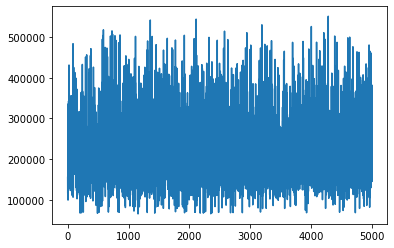

In [879]:
submit['Price'].plot()

<AxesSubplot:>

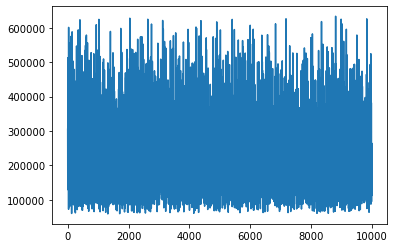

In [880]:
train_df['Price'].plot()